In [1]:
import os
import joblib
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
!dir

 Volume in drive D is New Volume
 Volume Serial Number is DC85-82A4

 Directory of D:\Github\DanhgiaDuAnVaNghenghiepTuongLai\code_ai\TestCode_ver4

06/26/2024  02:46 PM    <DIR>          .
06/26/2024  02:00 PM    <DIR>          ..
06/26/2024  02:20 PM    <DIR>          .idea
06/26/2024  02:45 PM        20,591,039 best_model.keras
06/26/2024  02:45 PM               760 categories.joblib
06/26/2024  02:43 PM                30 config.txt
06/13/2024  05:43 PM             4,773 predict.ipynb
06/26/2024  02:46 PM           194,488 RunCode1.ipynb
06/26/2024  02:45 PM            30,475 tokenizer.joblib
06/26/2024  02:43 PM            18,720 uncategorized_projects.csv
               7 File(s)     20,840,285 bytes
               3 Dir(s)  111,263,531,008 bytes free


In [3]:
# Xóa file mô hình cũ nếu tồn tại
if os.path.exists('best_model.keras'):
    os.remove('best_model.keras')
    os.remove('categories.joblib')
    os.remove('tokenizer.joblib')
    os.remove('uncategorized_projects.csv')

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Hàm xây dựng mô hình tối ưu
def build_model(vocab_size, num_classes, input_length):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=128, input_length=input_length),
        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.5),
        Bidirectional(LSTM(64)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')  # Sử dụng activation 'sigmoid' cho phân loại đa nhãn
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
# Hàm vẽ biểu đồ
def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Biểu đồ Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Biểu đồ Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
# Tạo từ điển ánh xạ với nhóm từ khóa cho mỗi chủ đề
technically = {
    'website': ['website', 'web'],
    'mobile-app': ['mobile app', 'app di động', 'Xây dựng ứng dụng', 'Xây dựng Ứng dụng', 'Ứng dụng di động', 'Phát triển ứng dụng', 'Xây dựng ứng dụng', 'hệ thống nhận diện'],
    'game': ['game', 'trò chơi'],
    'chatbot': ['chatbot', 'chat bot'],
    'artificial-intelligence': ['trí tuệ nhân tạo', 'Yolo', 'AIOT'],
    'machine-learning': ['machine learning', 'máy học'],
    'deep-learning': ['deep learning', 'học sâu'],
    'computer-vision': ['computer vision', 'thị giác máy tính'],
    'big-data': ['big data', 'dữ liệu lớn', 'bigdata'],
    'data-analysis': ['data analysis', 'phân tích dữ liệu'],
    'cloud-computing': ['cloud computing', 'điện toán đám mây', 'K8s', 'kubernetes'],
    'blockchain': ['blockchain', 'chuỗi khối', 'NFT'],
    'robot': ['robot', 'robotics', 'robotic'],
    'drone': ['drone', 'flycam'],
    'vr': ['vr', 'thực tế ảo', 'virtual reality'],
    'iot': ['nhà thông minh', 'thiết bị thông minh', 'AIOT', 'iot', 'ESP32', 'MQTT', 'vườn thông minh'],
}

In [8]:
# Tải dữ liệu
pd_data = pd.read_csv('D:/Github/DanhgiaDuAnVaNghenghiepTuongLai/dataset/dataset_train_ver1.csv')
pd_data

,STT,nameProject_VNI,nameProject_ENG,course,difficulty_level,codeSememter,major,specialization,university,note
0,1.0,Xây dựng hệ thống quản lý sân cầu lông,NaN,NaN,1.0,232.0,NaN,NaN,UIT,NaN
1,2.0,Tìm hiểu công nghệ Web 3.0 và ứng dụng web 3.0...,NaN,NaN,1.0,232.0,NaN,NaN,UIT,NaN
2,3.0,Xây dựng hệ thống trợ giúp tư vấn hướng nghiệp...,NaN,NaN,1.0,232.0,NaN,NaN,UIT,NaN
3,4.0,Xây dựng mạng xã hội kết hợp chatbot cho người...,NaN,NaN,1.0,232.0,NaN,NaN,UIT,NaN
4,5.0,Tìm hiểu Chatbot và xây dựng ứng dụng hỗ trợ t...,NaN,NaN,1.0,232.0,NaN,NaN,UIT,NaN
...,...,...,...,...,...,...,...,...,...,...
854,NaN,Ứng dụng Blockchain trong quản lý hệ thống chă...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
855,NaN,Phát triển hệ thống quản lý thông tin bảo hiểm...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
856,NaN,Ứng dụng Blockchain trong quản lý dịch vụ hưu ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
857,NaN,Blockchain và bảo mật trong dịch vụ bảo mật th...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_train = pd_data[['nameProject_VNI']].copy()

# Đếm số lần xuất hiện của mỗi tên dự án
project_counts = df_train['nameProject_VNI'].value_counts()
# Hiển thị các tên dự án có số lần xuất hiện nhiều hơn 1
duplicate_projects = project_counts[project_counts > 1]
print(duplicate_projects)

nameProject_VNI
Nghiên cứu và thử nghiệm một số phương pháp định giá BĐS                                                                          4
Tìm hiểu Thị giác máy tính vận dụng trong phát triển ứng dụng Game 3D tương tác, Thực thể ảo AR.                                  3
Phát triển ứng dụng phân tích dữ liệu y khoa trong xét nghiệm máu                                                                 3
Hệ thống nhà thông minh                                                                                                           3
Nhà thông minh                                                                                                                    2
Ứng dụng Trí Tuệ Nhận Diện Khuôn Mặt                                                                                              2
Ứng dụng MQTT trong nhà thông minh                                                                                                2
Ứng dụng trí tuệ nhân tạo phát hiện và phân loại khối u não 

In [10]:
# Lọc và hiển thị các bản ghi có tên dự án trùng lặp
duplicates = df_train[df_train['nameProject_VNI'].isin(duplicate_projects.index)]
# print(duplicates)

# Loại bỏ các trùng lặp, chỉ giữ lại bản ghi đầu tiên
df = df_train.drop_duplicates(subset=['nameProject_VNI'], keep='first')

In [11]:
# Đếm số lần xuất hiện của mỗi tên dự án
project_counts = df['nameProject_VNI'].value_counts()
# Hiển thị các tên dự án có số lần xuất hiện nhiều hơn 1
duplicate_projects = project_counts[project_counts > 1]
print(duplicate_projects)

Series([], Name: count, dtype: int64)


In [12]:
# df['category'] = df['nameProject_VNI'].apply(categorize_project)
# # pd_data
print(df)

                                       nameProject_VNI
0               Xây dựng hệ thống quản lý sân cầu lông
1    Tìm hiểu công nghệ Web 3.0 và ứng dụng web 3.0...
2    Xây dựng hệ thống trợ giúp tư vấn hướng nghiệp...
3    Xây dựng mạng xã hội kết hợp chatbot cho người...
4    Tìm hiểu Chatbot và xây dựng ứng dụng hỗ trợ t...
..                                                 ...
853  Blockchain và bảo mật trong dịch vụ tư vấn tài...
854  Ứng dụng Blockchain trong quản lý hệ thống chă...
855  Phát triển hệ thống quản lý thông tin bảo hiểm...
856  Ứng dụng Blockchain trong quản lý dịch vụ hưu ...
857  Blockchain và bảo mật trong dịch vụ bảo mật th...

[801 rows x 1 columns]


In [13]:
# Hàm phân loại chủ đề
def categorize_project(project_name):
    matched_themes = []
    for theme, keywords in technically.items():
        if any(keyword.lower() in project_name.lower() for keyword in keywords):
            matched_themes.append(theme)
    return ', '.join(matched_themes) if matched_themes else None

# Assuming df is your DataFrame and it's already defined
# Make sure to directly modify the 'category' column in a safe manner
df.loc[:, 'category'] = df['nameProject_VNI'].apply(lambda x: categorize_project(x) if categorize_project(x) else '')

# Tìm các hàng không có category được phân loại và lưu vào một file CSV mới
uncategorized_df = df[df['category'] == '']
uncategorized_df.to_csv('uncategorized_projects.csv', index=False, encoding='utf-8')

# Hiển thị các hàng không có category được phân loại
print("Các hàng không có category được phân loại:")
print(df[df['category'] == ''])

# Loại bỏ các hàng không có category được phân loại
df = df[df['category'] != '']

# Hiển thị DataFrame đã cập nhật
print("\nDataFrame sau khi loại bỏ các hàng không có category được phân loại:")
print(df)

Các hàng không có category được phân loại:
                                       nameProject_VNI category
0               Xây dựng hệ thống quản lý sân cầu lông         
2    Xây dựng hệ thống trợ giúp tư vấn hướng nghiệp...         
6    Nghiên cứu và thử nghiệm một số phương pháp đị...         
8    Xây dựng hệ thống quản lý phòng trọ và gợi ý c...         
10   Xây dựng Shop quần áo online tích hợp gợi ý sả...         
..                                                 ...      ...
728    Phát hiện bệnh trên lá của cây cà chua bằng CNN         
740               Ứng dụng Trí Tuệ Nhận Diện Khuôn Mặt         
742               Ứng dụng phát hiện ung thư đại tràng         
743  Nhận diện bàn tay đoán ra kí tự người khuyết t...         
762   Hợp đồng thông minh cho hệ thống bầu cử điện tử.         

[263 rows x 2 columns]

DataFrame sau khi loại bỏ các hàng không có category được phân loại:
                                       nameProject_VNI             category
1    Tìm hiểu công 

C:\Users\huuth\AppData\Local\Temp\ipykernel_30004\2065964452.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'category'] = df['nameProject_VNI'].apply(lambda x: categorize_project(x) if categorize_project(x) else '')


<Axes: xlabel='count', ylabel='university'>

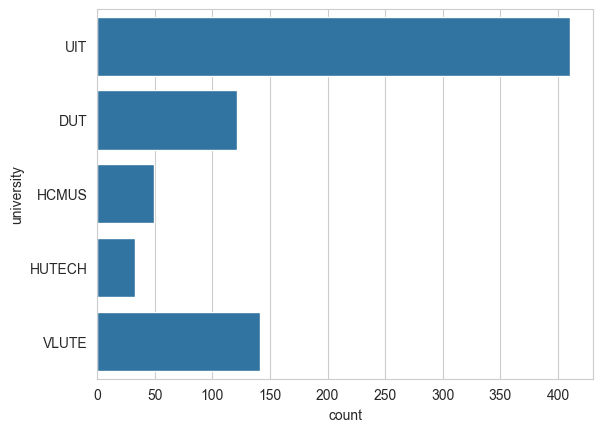

In [14]:
# UIT: Đại học Công nghệ thông tin HCM
# DUT: Đại học Đại học Bách Khoa - Đại học Đà Nẵng
# HCMUS: Đại học Khoa học Tự nhiên - Đại học Quốc gia TP.HCM
import seaborn as sns
sns.countplot(pd_data['university'])

In [15]:
# Số lượng đồ án của từng trường ĐH
pd_data['university'].value_counts()

university
UIT       410
VLUTE     141
DUT       121
HCMUS      49
HUTECH     33
Name: count, dtype: int64

In [16]:
# Tạo các cột chỉ báo cho mỗi chủ đề
category_dummies = pd.get_dummies(df['category'].apply(lambda x: x.split(', ')).explode()).groupby(level=0).sum()
df = pd.concat([df, category_dummies], axis=1)
df

,nameProject_VNI,category,artificial-intelligence,big-data,blockchain,chatbot,cloud-computing,computer-vision,data-analysis,deep-learning,drone,game,iot,machine-learning,mobile-app,robot,website
1,Tìm hiểu công nghệ Web 3.0 và ứng dụng web 3.0...,website,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Xây dựng mạng xã hội kết hợp chatbot cho người...,chatbot,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Tìm hiểu Chatbot và xây dựng ứng dụng hỗ trợ t...,"mobile-app, chatbot",0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
5,Tìm hiểu Chatbot và xây dựng ứng dụng hỗ trợ t...,"mobile-app, chatbot",0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
7,Phân tích xu hướng bất động sản bằng Machine L...,machine-learning,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,Blockchain và bảo mật trong dịch vụ tư vấn tài...,blockchain,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
854,Ứng dụng Blockchain trong quản lý hệ thống chă...,blockchain,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
855,Phát triển hệ thống quản lý thông tin bảo hiểm...,blockchain,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
856,Ứng dụng Blockchain trong quản lý dịch vụ hưu ...,blockchain,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# Lấy văn bản dự án và các nhãn
texts = df['nameProject_VNI'].values
categories = df.columns.difference(['nameProject_VNI', 'category'])
labels = df[categories].values

In [18]:
categories

Index(['artificial-intelligence', 'big-data', 'blockchain', 'chatbot',
       'cloud-computing', 'computer-vision', 'data-analysis', 'deep-learning',
       'drone', 'game', 'iot', 'machine-learning', 'mobile-app', 'robot',
       'website'],
      dtype='object')

In [19]:
print(labels)

[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [20]:
# Chuẩn bị tokenizer và padding
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(texts)
# Chuyển đổi văn bản thành chuỗi số
sequences = tokenizer.texts_to_sequences(texts)
max_length = max(len(seq) for seq in sequences)
data = pad_sequences(sequences, maxlen=max_length)

# Lưu các thông tin vào file txt
with open('config.txt', 'w') as file:
    file.write(f'MaxLength:{max_length}\n')
    file.write(f'NumWords:{num_words}\n')

In [21]:
# Chia dữ liệu thành huấn luyện và thử nghiệm
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [22]:
num_classes = y_train.shape[1]  # Đảm bảo num_classes bằng với kích thước thứ hai của y_train

# Khởi tạo mô hình
model = build_model(vocab_size=10000, num_classes=num_classes, input_length=max_length)

D:\moitruongao\dacs\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [23]:
print("Số lượng nhãn (num_classes):", num_classes)
print("Shape của y_train:", y_train.shape)
print("Shape của y_test:", y_test.shape)

Số lượng nhãn (num_classes): 15
Shape của y_train: (430, 15)
Shape của y_test: (108, 15)


In [24]:
# Early stopping và checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [25]:
num_rows = X_train.shape[0]
print(f"Số lượng hàng trong dữ liệu train là {num_rows}")
batch_size_options = [16, 32, 64]  # Các lựa chọn thử nghiệm

# Chọn batch size dựa trên hiệu suất của mô hình
batch_size = min(batch_size_options, key=lambda x: abs(x - num_rows//x * x))

print(f"Batch size được chọn: {batch_size}")

Số lượng hàng trong dữ liệu train là 430
Batch size được chọn: 64


In [26]:
history = []
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=500, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint])

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - accuracy: 0.0699 - loss: 0.9836 - val_accuracy: 0.0463 - val_loss: 0.6817
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.2425 - loss: 0.8775 - val_accuracy: 0.1759 - val_loss: 0.6680
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4425 - loss: 0.8143 - val_accuracy: 0.2130 - val_loss: 0.6560
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.5829 - loss: 0.7625 - val_accuracy: 0.4630 - val_loss: 0.6490
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7087 - loss: 0.7066 - val_accuracy: 0.4537 - val_loss: 0.6395
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7752 - loss: 0.6680 - val_accuracy: 0.5463 - val_loss: 0.6276
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.8221 - loss: 0.6481 - val_accuracy: 0.6111 - val_loss: 0.6122
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.8355 - loss: 0.6166 - val_accuracy: 0.6204 - 

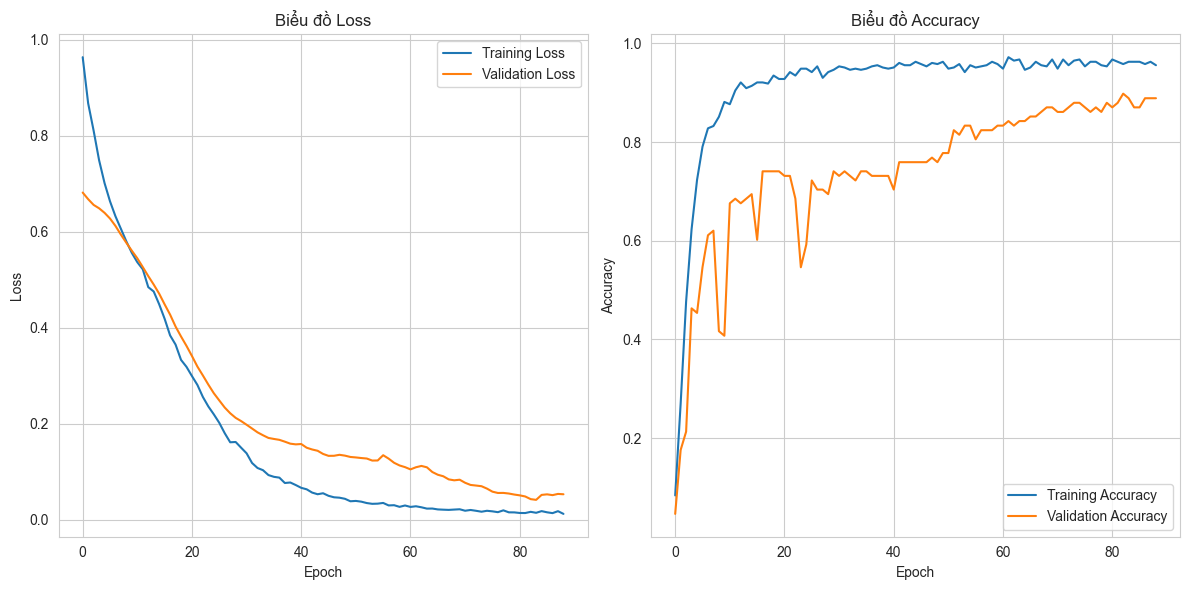

In [27]:
# Vẽ biểu đồ loss và accuracy
plot_history(history)

In [28]:
print(f"Số lượng categories: {len(categories)}")
print(f"Số lượng outputs của mô hình: {num_classes}")

Số lượng categories: 15
Số lượng outputs của mô hình: 15


In [29]:
# Lưu tokenizer và categories
joblib.dump(categories, 'categories.joblib')
joblib.dump(tokenizer, 'tokenizer.joblib')

# Định nghĩa và sử dụng hàm dự đoán
def predict_project_category(project_name):
    # Chuyển đổi tên dự án thành chuỗi số
    sequence = tokenizer.texts_to_sequences([project_name])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)  # Sử dụng max_length đã xác định khi huấn luyện

    # Thực hiện dự đoán
    prediction = model.predict(padded_sequence)
    predicted_categories = (prediction > 0.1).astype(int)

    # Ánh xạ dự đoán thành tên chủ đề
    predicted_labels = [categories[idx] for idx, is_present in enumerate(predicted_categories[0]) if is_present]
    return ', '.join(predicted_labels) if predicted_labels else 'Không xác định'

In [30]:
# Computer Science - AI
# Xây dựng hệ thống chatbot tự động tư vấn tuyển sinh
# Dự đoán doanh thu bán hàng dựa trên phân tích dữ liệu
# Phân loại cảm xúc trong văn bản tiếng Việt
# Nhận dạng giọng nói và chuyển đổi thành văn bản tiếng Việt
# Hệ thống phát hiện gian lận giao dịch ngân hàng
# Ứng dụng AI trong phân tích y học
# Xây dựng hệ thống đề xuất sản phẩm dựa trên sở thích khách hàng
# Phân loại ảnh và nhận diện đối tượng trong môi trường thực tế
# Hệ thống quản lý học tập thông minh
# Tối ưu hóa lộ trình vận chuyển hàng hóa

# Dùng website để mua đồ chơi cho trẻ
# Dùng website để quản trị nhà máy điện
# Xây dựng ứng dụng để quản lý thiết bị thông minh - X

In [35]:
# project_name = "Xây dựng ứng dụng để quản lý thiết bị thông minh"
# project_name = "Lập trình trí tuệ nhân tạo để dự đoán giá nhà"
# project_name = "Sử dụng blockchain vào hệ thống ngân hàng"
# project_name = "Dùng website để quản trị nhà máy điện" # Ngoài lề - đã add
# project_name = "Ứng dụng AI trong phân tích y học" # Ngoài lề - đã add
# project_name = "Xây dựng hệ thống chatbot tự động tư vấn tuyển sinh" # X
# project_name = "Dùng website để mua đồ chơi cho trẻ" # Ok
project_name = "Xây dựng ứng dụng để cải thiện hiệu xất văn phòng"
predicted_category = predict_project_category(project_name)
print(f"Đề tài: {project_name}\nThuộc các chủ đề: {predicted_category}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Đề tài: Xây dựng ứng dụng để cải thiện hiệu xất văn phòng
Thuộc các chủ đề: mobile-app
